In [13]:
import librosa
from aubio import source, onset
import numpy as np
import os
from os.path import join
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
wav_lst = os.listdir('outputs')
sr = 24000

## Librosa

In [60]:
def librosa_onsets(file_path, fs=24000, mode='env'):
    signal, fs = librosa.load(file_path, sr=fs)
    
    if mode == 'time':
        ### wait: gap between peaks; pre/post_max/avg: windowing; delta: threshold ###
        onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True, 
                                              wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1, delta=0.1)
        #onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True)
    elif mode == 'env':
        o_env = librosa.onset.onset_strength(signal, sr=fs)
        times = librosa.times_like(o_env, sr=fs)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=fs, backtrack=True)
        onset_ts = librosa.frames_to_time(onset_frames)
        
        D = np.abs(librosa.stft(signal))
        fig, ax = plt.subplots(1, 1)
        ax.set_title('Librosa Onset Detection')
        ax.plot(times, o_env, label='Onset strength')
        ax.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
        ax.legend()
        ax.set_xlabel('Time (s)')
    else:
        raise ValueError("Do not support this mode!")
        
    return onset_ts

In [24]:
signal ,fs = librosa.load(join('outputs', wav_lst[0]), sr=sr)

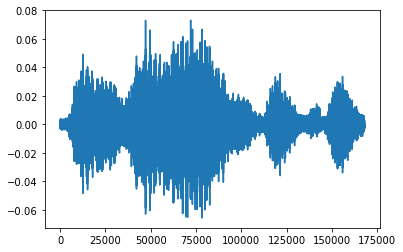

In [25]:
plt.plot(signal)
plt.show()

array([  3,   5,  14,  20,  27,  33,  35,  42,  45,  53,  55,  60,  66,
        72,  79,  83,  86,  97, 107, 113, 117, 122, 124, 129, 132, 134,
       140, 142, 145, 147, 150, 155, 157, 160, 163, 168, 187, 200, 217,
       223, 244, 252, 272, 282, 290, 298, 310, 314, 319, 322, 326])

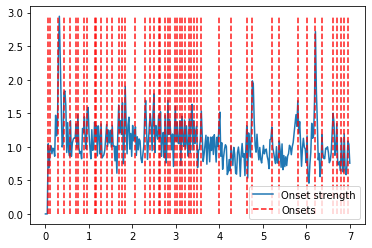

In [38]:
librosa_onsets(join('outputs', wav_lst[0]))

array([  2,   4,  12,  18,  26,  32,  34,  41,  44,  51,  54,  59,  61,
        71,  77,  82,  84,  95, 104, 110, 115, 121, 123, 128, 130, 133,
       138, 141, 144, 146, 149, 154, 156, 159, 161, 164, 186, 199, 215,
       221, 241, 251, 271, 281, 288, 296, 306, 312, 318, 321, 324])

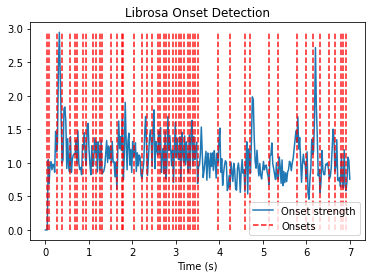

In [43]:
librosa_onsets(join('outputs', wav_lst[0]))  # After backtrack=True

In [46]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time'

array([0.04266667, 0.08533333, 0.256     , 0.384     , 0.55466667,
       0.68266667, 0.72533333, 0.87466667, 0.93866667, 1.088     ,
       1.152     , 1.25866667, 1.30133333, 1.51466667, 1.64266667,
       1.74933333, 1.792     , 2.02666667, 2.21866667, 2.34666667,
       2.45333333, 2.58133333, 2.624     , 2.73066667, 2.77333333,
       2.83733333, 2.944     , 3.008     , 3.072     , 3.11466667,
       3.17866667, 3.28533333, 3.328     , 3.392     , 3.43466667,
       3.49866667, 3.968     , 4.24533333, 4.58666667, 4.71466667,
       5.14133333, 5.35466667, 5.78133333, 5.99466667, 6.144     ,
       6.31466667, 6.528     , 6.656     , 6.784     , 6.848     ,
       6.912     ])

In [61]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time' with peak_pick args

array([0.04266667, 0.21333333, 0.256     , 0.384     , 1.792     ,
       2.73066667, 2.77333333, 3.11466667, 4.65066667, 4.71466667,
       6.144     ])

In [62]:
lib_count_lst = []

for file in os.listdir('outputs'):
    onset_time = librosa_onsets(join('outputs', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    
print(lib_count_lst)

[(11, [0.042666666666666665, 0.21333333333333335, 0.256, 0.384, 1.792, 2.7306666666666666, 2.7733333333333334, 3.1146666666666665, 4.650666666666667, 4.714666666666667, 6.144]), (21, [0.042666666666666665, 1.472, 1.6213333333333333, 1.728, 1.8346666666666667, 1.8986666666666667, 2.048, 3.6906666666666665, 4.629333333333333, 4.757333333333333, 4.928, 5.738666666666667, 6.101333333333334, 6.144, 6.378666666666667, 6.464, 7.808, 8.426666666666666, 8.768, 9.173333333333334, 9.685333333333332]), (29, [0.042666666666666665, 2.24, 2.3893333333333335, 2.538666666666667, 2.688, 2.752, 3.8186666666666667, 4.032, 5.12, 5.184, 5.290666666666667, 5.354666666666667, 5.504, 5.888, 5.952, 6.208, 6.272, 6.421333333333333, 6.485333333333333, 7.168, 7.36, 7.594666666666667, 7.658666666666667, 8.405333333333333, 8.704, 8.810666666666666, 9.002666666666666, 9.472, 9.962666666666667]), (13, [0.042666666666666665, 0.4266666666666667, 1.28, 1.472, 1.5573333333333332, 2.0906666666666665, 2.1973333333333334, 2.

In [63]:
assert len(lib_count_lst)==len(gt_lst)
lib_error_count = []
lib_error_onset_t = []
for idx, tup in enumerate(lib_count_lst):
    lib_error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(lib_error_count) / len(lib_error_count))

12.2


## Aubio

In [1]:
def get_onset_times(file_path):
    window_size = 1024 # FFT size
    hop_size = window_size // 4

    sample_rate = 0
    src_func = source(file_path, sample_rate, hop_size)
    sample_rate = src_func.samplerate
    onset_func = onset('default', window_size, hop_size)
    
    duration = float(src_func.duration) / src_func.samplerate

    onset_times = [] # seconds
    while True: # read frames
        samples, num_frames_read = src_func()
        if onset_func(samples):
            onset_time = onset_func.get_last_s()
            if onset_time < duration:
                onset_times.append(onset_time)
            else:
                break
        if num_frames_read < hop_size:
            break
    
    return onset_times

In [7]:
file_path = join('outputs', wav_lst[0])
onset_times = get_onset_times(file_path)

In [11]:
count_lst = []

for file in os.listdir('outputs'):
    onset_time = get_onset_times(join('outputs', file))
    count_lst.append((len(onset_time), onset_time))
    
print(count_lst)

[(10, [0.0, 1.334308385848999, 1.3935147523880005, 1.4508843421936035, 1.511950135231018, 1.5714513063430786, 1.629569172859192, 1.7495918273925781, 1.8089796304702759, 2.099682569503784]), (5, [0.0, 2.517437696456909, 2.5994105339050293, 3.1590023040771484, 3.8524036407470703]), (14, [0.0, 2.8123583793640137, 2.9293878078460693, 2.988616704940796, 3.0461678504943848, 3.10569167137146, 3.1661224365234375, 3.344149589538574, 3.402585029602051, 3.4634695053100586, 4.905079364776611, 4.965396881103516, 5.024625778198242, 5.082766532897949]), (8, [0.0, 0.87034010887146, 1.4771201610565186, 1.5983673334121704, 1.901610016822815, 1.9607256650924683, 2.076326608657837, 2.1402721405029297]), (9, [0.0, 2.7684807777404785, 2.8294103145599365, 2.887460231781006, 2.9454421997070312, 3.0050339698791504, 3.0641496181488037, 3.185147285461426, 3.243197202682495]), (1, [0.0]), (11, [0.0, 0.6227437853813171, 0.6820635199546814, 0.7408390045166016, 0.7993423938751221, 0.8579365015029907, 0.9199319481849

In [16]:
with open('annotations.json') as f:
    anns = json.load(f)

### Ground-truth

In [21]:
gt_lst = []

for file in os.listdir('outputs'):
    key_name = file.split('.')[0]
    
    start_ts = [item['start_t'] for item in anns[key_name]['birds']]
    
    gt_lst.append((anns[key_name]['count'], sorted(start_ts)))
    
print(gt_lst)

[(10, [0.015876305004615496, 0.04055874747533283, 0.8560014930756557, 1.113190095751739, 1.4673785172424894, 1.8090983152621483, 1.9343189066546818, 2.1345905017997007, 4.339293069060367, 5.427446743592197]), (10, [0.37726755844016974, 0.39026541015092964, 0.865730286394628, 1.289283348606935, 1.3144453738689539, 2.045300700875337, 4.526546265432463, 4.606212095954632, 4.9642929183415685, 5.358079898350199]), (10, [2.0422582831429015, 2.4019279826428646, 3.684572612475001, 4.631383724230315, 5.174263512148089, 5.808403381671271, 7.213222444554427, 7.247640891734407, 8.61479029189398, 9.305477105584105]), (10, [0.08957469750368154, 0.7055040435527499, 0.7437540168754013, 1.1322561652724625, 1.1368965504921866, 2.508784130854608, 2.9445331997541864, 3.1993645288836, 3.36240098300053, 4.24348693561246]), (10, [0.7902820896082009, 0.8351156931336404, 0.9657154572200708, 2.8727539475059127, 4.742736772641742, 4.8263467105994025, 6.537025166068086, 7.504311641580494, 7.643364108606821, 7.805

In [22]:
assert len(count_lst)==len(gt_lst)
error_count = []
error_onset_t = []
for idx, tup in enumerate(count_lst):
    error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(error_count) / len(error_count))

3.6
